# Age & Access to Health Services

The data used in this notebook can be found at [this link](https://drive.google.com/drive/folders/1kNZ90Q8cwMqmiBW4fKqkl9caIWy3dvGi?usp=share_link). File paths should be adjusted accordingly.

Created on Google Colabs.

## Packages

In [ ]:
!pip install numpy pandas geopandas seaborn matplotlib matplotlib_scalebar scikit-learn networkx cdlib contextily

import re
import os
import copy
from math import sqrt
from scipy.spatial import Delaunay
from scipy.stats.mstats import winsorize

# Adjusting pandas display
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

# Importing the installed packages
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import igraph as ig
from cdlib import NodeClustering

from matplotlib.pyplot import cm
from shapely.geometry import Point
from collections import defaultdict # to make sure dictionary copies are better mirrors of the origional, https://docs.python.org/3/library/copy.html
import contextily as ctx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Census Data

In [ ]:
# path
folder_path = "YOUR_PATH_HERE/Data/2021 Census Features"

# List all files in the directory
all_files = os.listdir(folder_path)

# Get all the .csv files
csv_files = [file for file in all_files if file.endswith('.csv') or file.endswith('.CSV')]

# Print the list of CSV files
print("CSV files:")
print(csv_files)

# Create an empty list to hold dataframes
data_frames = []

# Loop over the list of csv files
for filename in csv_files:
    print(f"Loading file: {filename}")
    # Read CSV to dataframe
    df = pd.read_csv(os.path.join(folder_path, filename))
    # Append dataframe to the list
    data_frames.append(df)

# Print the number of dataframes
print(f"Loaded {len(data_frames)} dataframes.")

CSV files:
['Age2021.csv', 'Sex2021.csv', 'Disability2021.csv', 'Ethnicity2021.csv', 'Employment2021.csv', 'WorkDist2021.csv', 'HouseholdDep2021.csv', 'HouseholdType2021.csv', 'Cars2021.csv']
Loading file: Age2021.csv
Loading file: Sex2021.csv
Loading file: Disability2021.csv
Loading file: Ethnicity2021.csv
Loading file: Employment2021.csv
Loading file: WorkDist2021.csv
Loading file: HouseholdDep2021.csv
Loading file: HouseholdType2021.csv
Loading file: Cars2021.csv
Loaded 9 dataframes.


In [ ]:
# In order to get the concentration values
population_lsoa = data_frames[8].groupby("Lower layer Super Output Areas Code")["Observation"].sum()
population_df = population_lsoa.reset_index() # Convert the Series to a DataFrame
London_pop = population_df.Observation.sum()
data_frames[8] = data_frames[8].merge(population_df, how="left", on='Lower layer Super Output Areas Code')
data_frames[8].rename(columns={"Observation_x": "Observation", "Observation_y": "Population"}, inplace=True)

## Create the Census Vector to Reflect Concentrations

The Python script below is built to amalgamate multiple csv files into a single dictionary for more streamlined data handling when used as a vector. It builds a dictionary of dictionaries. It begins by initialising a counter (cc_counter), a dictionary (data_dict) to store the final dataset, and a DataFrame (cc_origin) to record the original census category values and their corresponding 'cc' codes.

The script iterates over each CSV file from the input list. Each file is loaded into a DataFrame, and any column containing the word 'code' (except the 'Lower layer Super Output Areas Code') is singled out. For each unique value in these 'code' columns, a new 'cc' code is generated (unless it has already been assigned one). The 'cc' code and the corresponding original value, along with the file it originated from, are then stored in the cc_origin DataFrame for reference in subsequent analyses. **NOTE: depending on the csvs are stored locally, some adjustments to the code below will need to be made when specific census categories are referenced. This is also true if applying this code to different case studies**

Next, for each DataFrame, the code below computes the concentration of each demographic group for each LSOA, iterating over each row in the DataFrame. For each row, it checks if the corresponding 'Lower layer Super Output Areas Code' (LSOA code) exists in the dictionary, if not, it creates a new dictionary for that LSOA code. Then, for each 'code' column in the row, the script assigns the 'cc' code as the key and the corresponding 'z_score' value as the value in the dictionary corresponding to the LSOA code.

In the end, 'data_dict' contains a comprehensive dictionary with each LSOA code mapping to another dictionary of 'cc' codes and their corresponding 'z_score' values. The cc_origin DataFrame, on the other hand, provides a lookup table for what each 'cc' code refers to in the original dataset.

In [ ]:
# Prepare the population data for calculating concentrations
population_df = data_frames[8].copy()
population_df.set_index("Lower layer Super Output Areas Code", inplace=True)

# Dictionary to store total populations of each LSOA
total_population_by_lsoa = population_df['Population'].to_dict()

# Calculate the total population of all LSOAs (entire London)
total_population_london = sum(total_population_by_lsoa.values())

# Dictionary to store total counts of each observation type across all LSOAs
total_counts = {}

###########################################################################################

# Initialise a counter for generating cc codes, a dictionary to hold the data, and a dataframe to hold cc origins
cc_counter = 1
data_dict = {}
cc_origin = pd.DataFrame(columns=['cc', 'origin_info', 'filename'])

for idx, df in enumerate(data_frames):
    print(f"Loading DataFrame: {idx}")

    # Extract column names containing 'categories)' and not 'code' so the unique census categories are selected
    code_columns = [col for col in df.columns if 'categories)' in col.lower() and 'code' not in col.lower()]

    # Update total counts for each observation type
    for col in code_columns:
        for code, count in df[df['Observation'] != 0].groupby(col)['Observation'].sum().items():
            total_counts[code] = total_counts.get(code, 0) + count

    # Generate 'cc' codes and store in the cc_origin dataframe
    code_to_cc = {}
    for col in code_columns:
        for code in df[col].unique():
            if code not in code_to_cc:
                cc_code = 'cc' + str(cc_counter)
                code_to_cc[code] = cc_code
                cc_counter += 1

                # Add to cc_origin dataframe
                cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)

    # Special handling for the population DataFrame
    if idx == 8:
        # Assign a 'cc' for the population column
        population_cc = 'cc' + str(cc_counter)
        cc_counter += 1

        # Add to cc_origin dataframe
        cc_origin = cc_origin.append({'cc': population_cc, 'origin_info': 'population', 'filename': idx}, ignore_index=True)

    # Calculate the actual concentrations and add to the dictionaries
    for i, row in df.iterrows():
        lsoa_code = row['Lower layer Super Output Areas Code']

        # If this code isn't in the dictionary yet, add it
        if lsoa_code not in data_dict:
            data_dict[lsoa_code] = {'census': {}}

        for col in code_columns:
            observation_type = row[col]
            cc_code = code_to_cc[observation_type]

            if row['Observation'] != 0:
                # Numerator: observation of group x in this LSOA / total population of this LSOA
                concentration_numerator = row['Observation'] / total_population_by_lsoa[lsoa_code]

                # Denominator: total number of group x for all of London / total population of London
                concentration_denominator = total_counts[observation_type] / total_population_london

                concentration = concentration_numerator / concentration_denominator
                data_dict[lsoa_code]['census'][cc_code] = concentration

        # Add the population to the dictionary using the 'cc' as the key, if it's the 9th dataframe
        if idx == 8:
            data_dict[lsoa_code]['census'][population_cc] = row['Population']

Loading DataFrame: 0


<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 1


<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)


Loading DataFrame: 2


<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)


Loading DataFrame: 3


<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 4


<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 5


<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 6


<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 7


<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 8


<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-8-1b315f73976c>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

In [ ]:
old_pop = data_frames[0][data_frames[0]['Age (6 categories) Code'] == 6]

# Create a list of tuples containing LSOA codes and their corresponding 'cc45' values
lsoa_cc6_values = [(lsoa_code, data['census'].get('cc6', np.nan)) for lsoa_code, data in data_dict.items()]

# Convert the list of tuples to a DataFrame
cc6_df = pd.DataFrame(lsoa_cc6_values, columns=['LSOA', 'cc6_value'])
old_pop_gdf = old_pop.merge(cc6_df, left_on='Lower layer Super Output Areas Code', right_on ="LSOA")

In [ ]:
lsoas2021 = gpd.read_file('YOUR_PATH_HERE/Data/LSOA_Dec_2021_Boundaries_Generalised_Clipped_EW_BGC_2022_5000101660793162025/LSOA_2021_EW_BGC.shp')
lsoas2021['centroids'] = lsoas2021.geometry.centroid

In [ ]:
# List of London boroughs
london_boroughs = [
    "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley", "Camden", "City of London", "Croydon", "Ealing",
    "Enfield", "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow", "Havering",
    "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea", "Kingston upon Thames", "Lambeth",
    "Lewisham", "Merton", "Newham", "Redbridge", "Richmond upon Thames", "Southwark", "Sutton",
    "Tower Hamlets", "Waltham Forest", "Wandsworth", "Westminster"
]

# Subset the 'lsoas2021' shapefile by borough names
lsoas_london = lsoas2021[lsoas2021['LSOA21NM'].str.contains('|'.join(london_boroughs))]


In [ ]:
# Remove the last 5 characters from the LSOA21NM column
lsoas_london['LSOA21NM2'] = lsoas_london['LSOA21NM'].str[:-5]

# Get all unique values in the modified LSOA21NM column
unique_values = lsoas_london['LSOA21NM2'].unique()

# Display the unique values
print("Unique values:")
print(unique_values)

Unique values:
['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster' 'Brentwood']


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


An extra borough is included: Brentwood. This is because the regular expression to find the LSOAs captures Brentwood by accident.

In [ ]:
# Remove LSOAs containing "Brentwood" in LSOA21NM
lsoas_london = lsoas_london[~lsoas_london['LSOA21NM'].str.contains("Brentwood")]

# Drop the LSOA21NM2 column
lsoas_london = lsoas_london.drop(columns=['LSOA21NM2'])

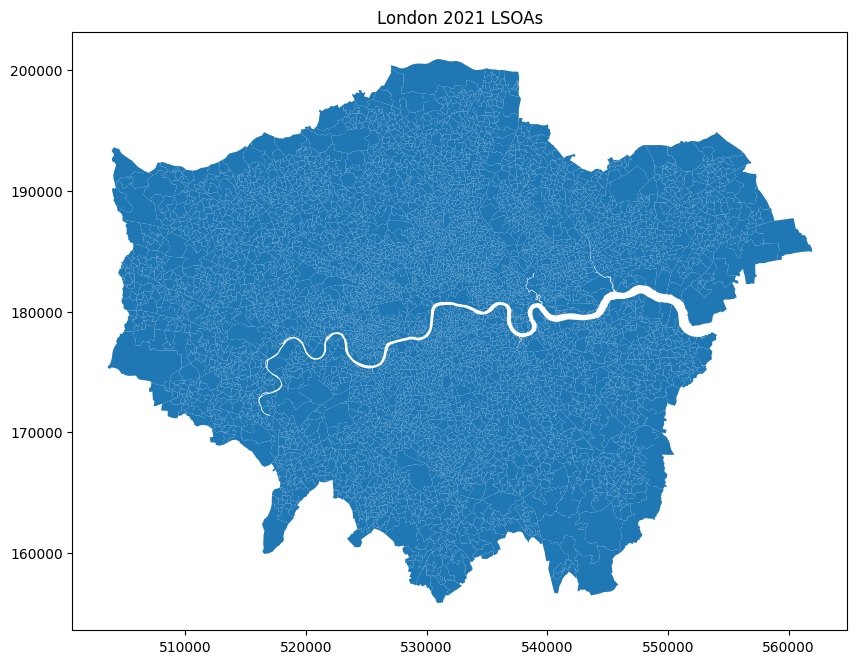

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
lsoas_london.plot(ax=ax)
ax.set_title("London 2021 LSOAs")
plt.show()

In [ ]:
lsoas_london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4994 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA21CD   4994 non-null   object  
 1   LSOA21NM   4994 non-null   object  
 2   GlobalID   4994 non-null   object  
 3   geometry   4994 non-null   geometry
 4   centroids  4994 non-null   geometry
dtypes: geometry(2), object(3)
memory usage: 234.1+ KB


Get the outline of the boroughs

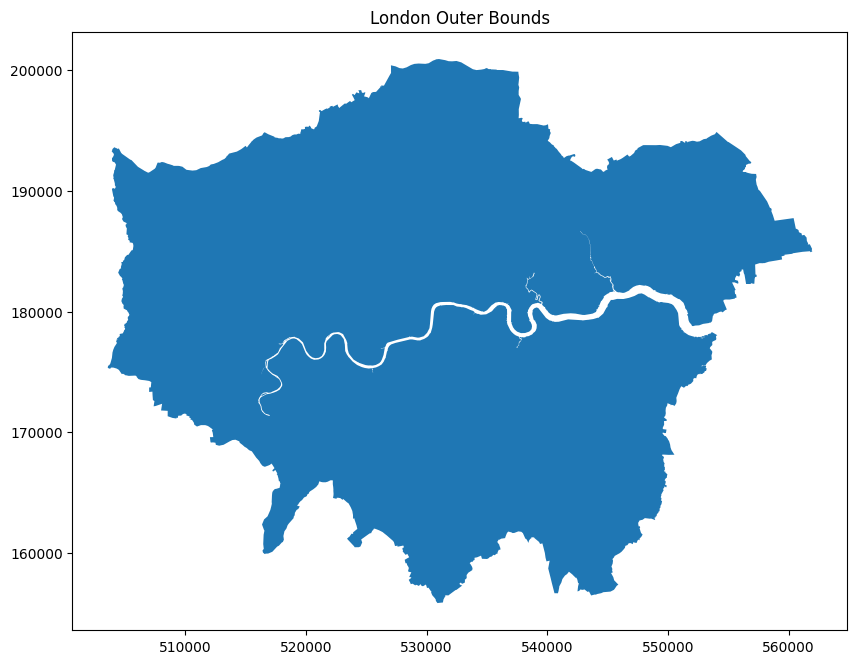

In [ ]:
all_london = lsoas_london.dissolve()
fig, ax = plt.subplots(figsize=(10, 10))
all_london.plot(ax=ax)
ax.set_title("London Outer Bounds")
plt.show()

In [ ]:
# Function to extract the London borough from the LSOA name
def extract_borough(lsoa_name):
    for borough in london_boroughs:
        if borough in lsoa_name:
            return borough
    return None

# Create a new column 'London_Borough' with the matched borough name for each LSOA
lsoas_london['London_Borough'] = lsoas_london['LSOA21NM'].apply(extract_borough)

# Create a new GeoDataFrame for London boroughs by dissolving the geometries of LSOAs within each borough
london_borough_gdf = lsoas_london.dissolve(by='London_Borough')

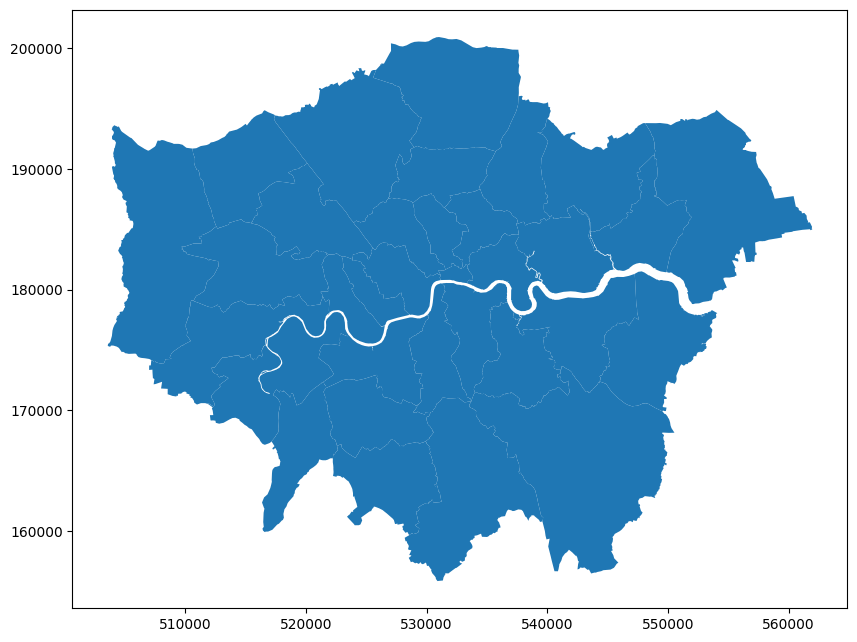

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
london_borough_gdf.plot(ax=ax)
plt.show()

In [ ]:
# lsoas_london_output = lsoas_london.drop(columns="centroids")
# lsoas_london_output.to_file("YOUR_PATH_HERE/Data/2021_lsoas")

## Reading in Access Data

In [ ]:
age = pd.read_csv("YOUR_PATH_HERE/Data/r5r Data/access_age.csv")

In [ ]:
age2 = age[(age["travel_time_p50"] != float('inf')) & (age["travel_time_p50"] != "NA")]
age2 = gpd.GeoDataFrame(age2, geometry=gpd.points_from_xy(age2.lon, age2.lat), crs="EPSG:4326")
age2 = age2.to_crs(crs="EPSG:27700")

In [ ]:
# Create new instances of old variables so nothing is overwritten
age_dict = copy.deepcopy(data_dict)
age_new = copy.deepcopy(age2)

## Multivariate Analysis

In [ ]:
# Select the columns from each dataframe
df1 = age2[['LSOA21CD','travel_time_p50', 'accessibility']]
df2 = data_frames[0].copy() # select your required columns if needed

# Pivot df2 to get each age category as a separate column
pivot_df2 = df2.pivot(index='Lower layer Super Output Areas Code',
                      columns='Age (6 categories)',
                      values='Observation')

# Reset the index
pivot_df2.reset_index(inplace=True)

# Merge df1 and pivot_df2 on 'Lower layer Super Output Areas Code'
combined_df = pd.merge(df1, pivot_df2, left_on='LSOA21CD', right_on='Lower layer Super Output Areas Code')

# Clean Dataframes
combined_df2 = combined_df.drop(columns=['LSOA21CD', 'Lower layer Super Output Areas Code'])
combined_df2 = combined_df2.rename(columns = {'travel_time_p50':'Travel Times', 'accessibility': 'Accessible Opportunities'})

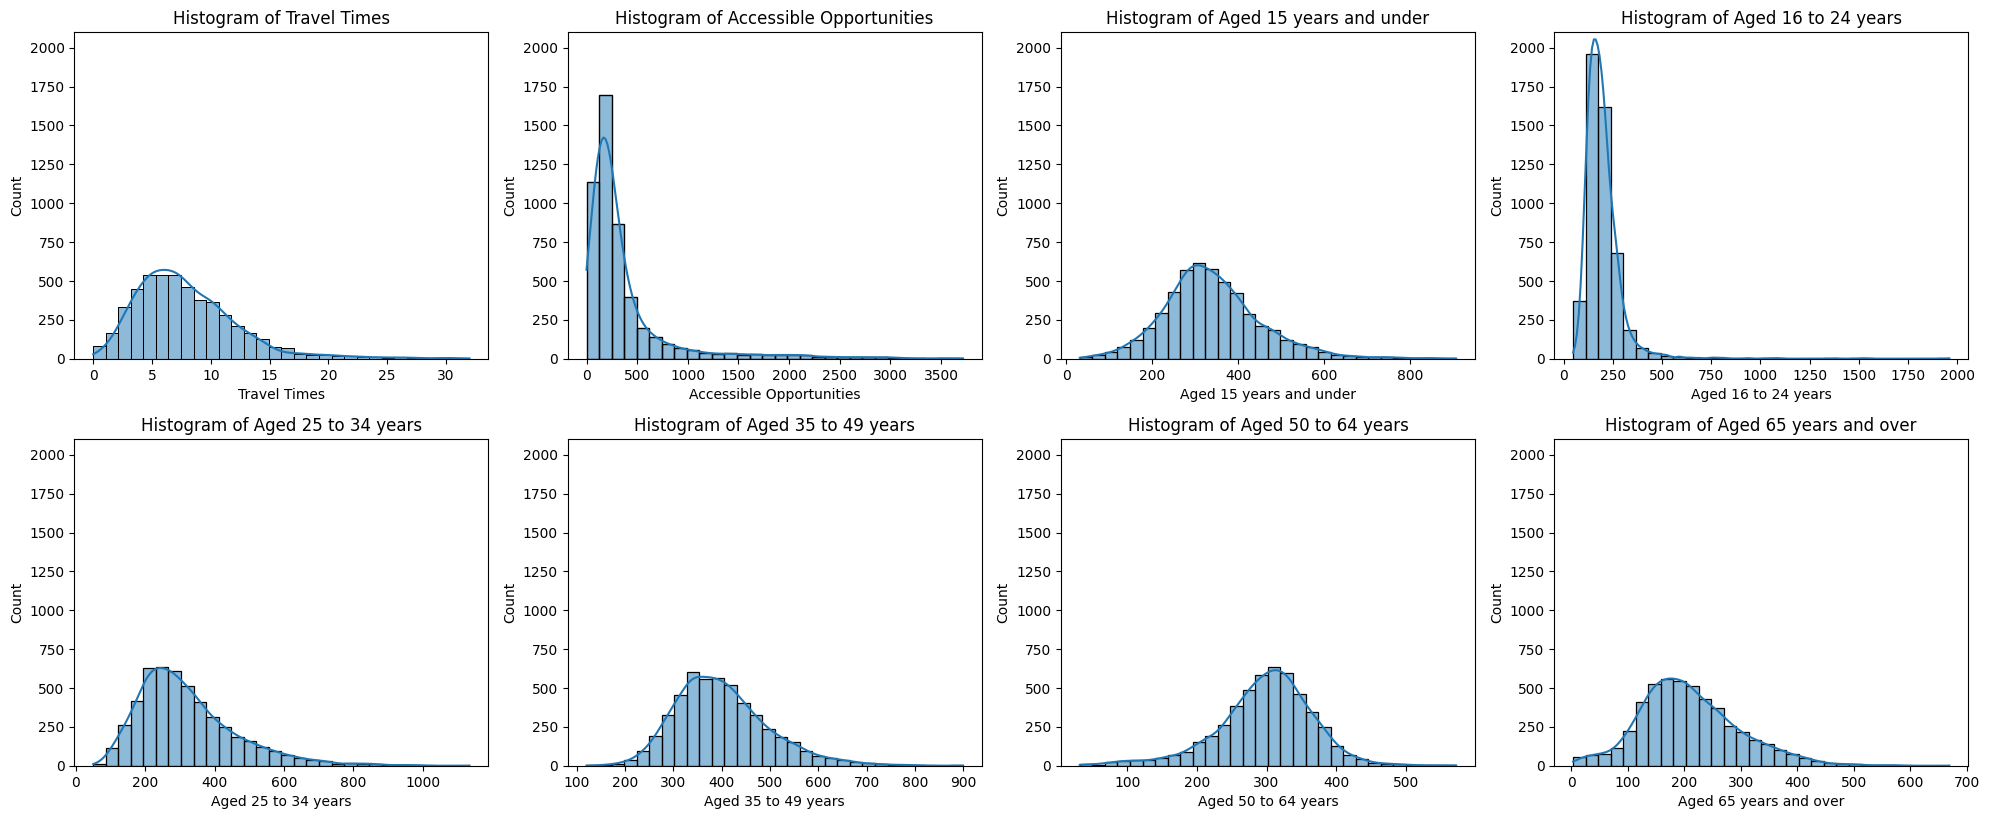

In [ ]:
# Set rows and columns for 2x4 grid
ncols = 4
nrows = 4

# Setting up the size of each plot; assume each subplot is 5x4
fig_width = 5 * ncols
fig_height = 4 * nrows

plt.figure(figsize=(fig_width, fig_height))

# Loop through the columns of combined_df2 and plot histograms
for index, col in enumerate(combined_df2.columns, start=1):
    if index > 8: =
        break
    plt.subplot(nrows, ncols, index)
    sns.histplot(combined_df2[col], bins=30, kde=True)
    plt.ylim([0,2100])
    plt.title(f'Histogram of {col}')
    plt.tight_layout()

plt.show()

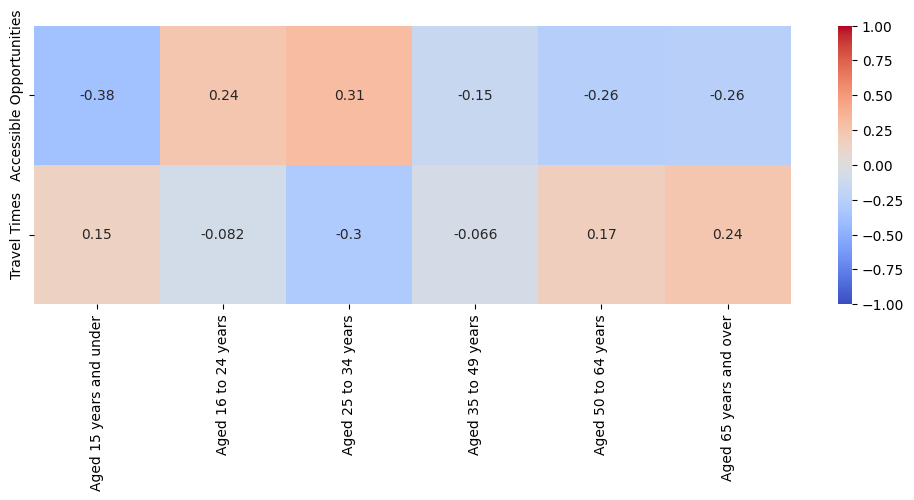

In [ ]:
# Calculate the correlation matrix
correlation_matrix = combined_df2.corr()

# Filter rows for "Accessible Opportunities" and "Travel Times"
filtered_rows = correlation_matrix.loc[["Accessible Opportunities", "Travel Times"], :]

# Drop columns "Accessible Opportunities" and "Travel Times"
filtered_matrix = filtered_rows.drop(columns=["Accessible Opportunities", "Travel Times"])

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Heatmap
sns.heatmap(filtered_matrix, annot=True, cmap='coolwarm', vmin=-1,vmax=1)

plt.tight_layout()
plt.show()

## Standardising Age Access Data

In [ ]:
# Create an instance of StandardScaler & Transform the df so it is all z_score based
scaler = StandardScaler()

# Transform the travel time values using the scaler
age_new['zscore_tt'] = scaler.fit_transform(age_new[['travel_time_p50']])

# Find the density and and then standardise it
age_new['density'] = age_new['accessibility']/24264 # This is the total number of health related POIs

age_new['density_zscore'] = scaler.fit_transform(age_new[['density']])

## Building Vectors

In [ ]:
# Iterate over the rows in age_new
for i, row in age_new.iterrows():
  # Get the LSOA21CD Value
  lsoa_code = row['LSOA21CD']
  # If this LSOA isn't in the dictionary yet, add the key-values
  if lsoa_code not in age_dict:
    age_dict[lsoa_code] = {
    'density_zscore':{'value': row['density_zscore']},
    'zscore_tt' : {'value': row['zscore_tt']}
    }
  # If the lsoa already has this data, just update it (in case there was a mistake earlier)
  else:
    for key in ['density_zscore', 'zscore_tt']:
      # Check if the key is a dictionary, if not initialise it as such:
      if type(age_dict[lsoa_code].get(key)) is not dict:
        age_dict[lsoa_code][key] = {}
      age_dict[lsoa_code][key]['value'] = row[key]

In [ ]:
age_dict['E01000001']

{'census': {'cc1': 0.33511757918291935,
  'cc2': 0.5148833069530787,
  'cc3': 1.0690147858494519,
  'cc4': 0.8621261116339295,
  'cc5': 0.6241941921326716,
  'cc6': 0.9890778733707107,
  'cc7': 0.6669180290862992,
  'cc8': 0.7997285976031903,
  'cc10': 0.43038783430502026,
  'cc11': 0.7960181829586853,
  'cc13': 0.1834245249354884,
  'cc14': 4.380080869703645,
  'cc15': 0.7773257571239587,
  'cc16': 0.037251594121164334,
  'cc17': 1.124676624687228,
  'cc18': 0.15895812841380635,
  'cc19': 0.14238345637264205,
  'cc21': 1.6965687183600182,
  'cc22': 0.9480340461143324,
  'cc23': 0.11529188631750784,
  'cc24': 1.1393937383435233,
  'cc25': 0.5480724097926584,
  'cc26': 1.864542977749188,
  'cc28': 3.222434660690777,
  'cc29': 2.54781741362731,
  'cc30': 1.9609304892205812,
  'cc31': 1.4728203525794261,
  'cc32': 0.33511757918291935,
  'cc33': 0.9389909008936826,
  'cc34': 0.6876834245255714,
  'cc35': 0.36350858403180497,
  'cc36': 0.5937886700869184,
  'cc37': 0.6735754670465389,
  'cc

The code below that builds the final set of vectors uses the values in cc dictionary created earlier. This should be double checked in case there was an issue loading in the dfs.

In [ ]:
# Create a new dictionary for the final vectors
final_vectors_age = {}

for lsoa_code, lsoa_data in age_dict.items():
  # Get the census columns from the data dictionary made above that relate to this case study.
  # cc6 here is what the score will be based on, but I keep the others for community detection
  one = lsoa_data['census']['cc1'] # corresponds to people Aged 15 years and under
  two = lsoa_data['census']['cc2'] # corresponds to people Aged 16 to 24 years
  three = lsoa_data['census']['cc3'] # corresponds to people Aged 25 to 34 years
  four = lsoa_data['census']['cc4'] # corresponds to people Aged 35 to 49 years
  five = lsoa_data['census']['cc5'] # corresponds to people Aged 50 to 64 years
  old = lsoa_data['census']['cc6'] # corresponds to people age 65 and older

  #Filter the agespace_new df to get rows corresponding to the LSOA codes
  age_data = age_new[age_new['LSOA21CD'] ==  lsoa_code]

  # If the LSOA code isn't in diction, then continue (in case there is an error)
  if age_data.empty:
    continue

  # Otherwise, get the accessibility values
  density = age_data['density_zscore'].values[0]
  tt = age_data['zscore_tt'].values[0]

  # Finally, combine these into a single vector to use when doing community detection on cosine similarity
  vector = np.array([one, two, three, four, five, old, density, tt])
  final_vectors_age[lsoa_code] = vector

## Calculate the Scores

There are several ways in which the scores are calculated. First, the below code returns a dictionary with the final scores for all LSOAs. Then, it returns an unscaled version of that score, and finally it returns a dictionary containing the components that go into the final score. This last one is used later when decomposing the indicator.

In [ ]:
# New dictionary for final scores relating to age
final_age_scores = {}
final_age_scores_all = {}
final_age_scores_unscaled = {}

for lsoa_code, lsoa_data in age_dict.items():
  # Get the relevant census columns, cc6 here is what the score will be based on.
  old = lsoa_data['census']['cc6'] # corresponds to people aged 65 and over

  # initialise variables for each lsoa which will later be changed when scaled
  scaled_density = 0
  scaled_tt = 0

  # Find the max z-score for inverting the travel time
  max_z = max([lsoa_data['zscore_tt']['value'] for lsoa_code, lsoa_data in age_dict.items() if 'zscore_tt' in lsoa_data])

  # Add scaled values to the dictionary
  if 'density_zscore' in lsoa_data:
    density = lsoa_data['density_zscore']['value']
    scaled_density = lsoa_data['density_zscore']['value']
  if 'zscore_tt' in lsoa_data:
    tt = (max_z-lsoa_data['zscore_tt']['value'])
    scaled_tt = max_z - lsoa_data['zscore_tt']['value']

  # Calculate the final scores
  final_score = density + tt

  unscaled_score = final_score  # Initialise unscaled_score here

  # Here, calculate the actual scores – scale by beta
  if lsoa_code in lsoas_london.index:
        area = lsoas_london.loc[lsoa_code, 'area']
        if area > 0:  # Avoid division by 0 in case there's an error in the data
            final_score = (final_score / area) * (1/old)
            unscaled_score = unscaled_score / area
            scaled_density = (scaled_density / area) * (1/old)
            scaled_tt = (scaled_tt / area) * (1/old)

  final_age_scores[lsoa_code] = final_score
  final_age_scores_unscaled[lsoa_code] = unscaled_score

  # Add it to the final score dictionary, the one for decomposition
  final_age_scores_all[lsoa_code] = {
        'final_score': final_score,
        'scaled_density': scaled_density,
        'scaled_tt': scaled_tt}

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

# Extract dictionary values to lists
final_age_scores_list = list(final_age_scores.values())
unscaled_age_scores_list = list(final_age_scores_unscaled.values())

# Convert the lists to numpy arrays, reshape them into 2D arrays and scale them
rescaled_final_age_scores = scaler.fit_transform(np.array(final_age_scores_list).reshape(-1, 1)).flatten()
rescaled_unscaled_age_scores = scaler.fit_transform(np.array(unscaled_age_scores_list).reshape(-1, 1)).flatten()

# Create new dictionaries with the LSOA codes and the corresponding scaled scores
final_age_scores_scaled = dict(zip(final_age_scores.keys(), rescaled_final_age_scores))
final_age_scores_unscaled_scaled = dict(zip(final_age_scores_unscaled.keys(), rescaled_unscaled_age_scores))

Basic plotting

In [ ]:
# Create a DataFrame from the scores dictionary
agescores_df = pd.DataFrame.from_dict(final_age_scores_scaled, orient='index', columns=['score'])
agescores_df.reset_index(inplace=True)
agescores_df.rename(columns={'index':'LSOA21CD'}, inplace=True)

In [ ]:
agescores_df['winsorised_score'] = winsorize(agescores_df['score'], limits=[0.005, 0.005])

In [ ]:
age_lsoas = lsoas_london.copy()

# Merge the lsoas_london shapefile with the standardised scores DataFrame based on the 'LSOA21CD' column
age_merged = age_lsoas.merge(agescores_df, on='LSOA21CD',how='left')

# Fill in missing values with 0
age_merged.fillna(0, inplace=True)

<Axes: >

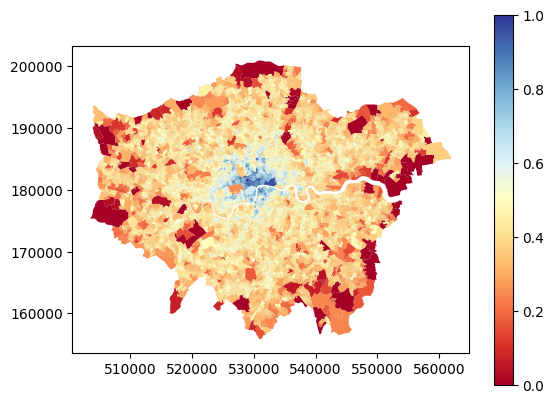

In [ ]:
age_merged.plot(column='score', cmap='RdYlBu', linewidth=0.01, edgecolor='Black', legend=True)

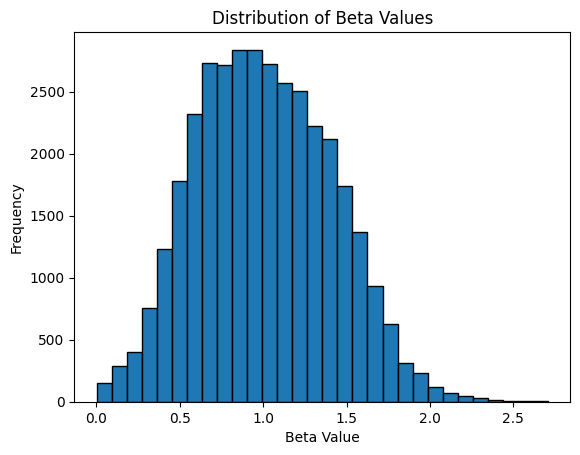

In [ ]:
# Extracting 'two' values
old_values = [lsoa_data['census']['cc6'] for lsoa_data in age_dict.values()]

# Calculate beta values from 'two' values
beta_values = [1 / val for val in old_values]

plt.hist(old_values, bins=30, edgecolor='black')
plt.title("Distribution of Beta Values")
plt.xlabel("Beta Value")
plt.ylabel("Frequency")
plt.show()

## Building the Network and Community Detection

In [ ]:
# Get the point geometry for the graph
age_points = age_new.merge(agescores_df, on='LSOA21CD')
columns_to_drop_networksetup = ['Unnamed: 0', 'V1', 'GlobalID', 'centroid_lat',
       'centroid_lon', 'lat', 'lon', 'id', 'travel_time_p50', 'opportunity',
       'percentile', 'cutoff', 'accessibility', 'zscore_tt', 'density',
       'density_zscore']
age_points2 = age_points.drop(columns = columns_to_drop_networksetup)

Clean the df to do delaunay triagnulation but buffer the edges based on the entire UK LSOA shapefile otherwise LSOAs that are not adjacent would have an edge and help make up a triangle.

In [ ]:
# Convert the final_vectors dictionary to a DataFrame
vectors_df = pd.DataFrame.from_dict(final_vectors_age, orient='index')
vectors_df = vectors_df.reset_index() # Resets the index and brings the LSOA codes back as a column
vectors_df.columns = ['LSOA21CD', 'vec1', 'vec2', 'vec3','vec4','vec5','vec6','vec7','vec8'] # Naming the columns

# Merge the vectors DataFrame with the DataFrame that contains the geometries
merged_vectors_df = pd.merge(vectors_df, age_points2, right_on='LSOA21CD', left_on='LSOA21CD')

# Merge vectors_df on 'LSOA21CD', this will ensure all LSOAs are included and then buffer
merged_df = pd.merge(lsoas2021, vectors_df, how='left', on='LSOA21CD')

# Replace any NaN values in the DataFrame with 0
merged_df[['vec1','vec2','vec3','vec4','vec5','vec6','vec7','vec8']] = merged_df[['vec1','vec2','vec3','vec4','vec5','vec6','vec7','vec8']].fillna(0)

merged_df = merged_df.drop(columns={"geometry"})

Create the Delaunay Triangulation

In [ ]:
# Initialise a new graph
G_full = nx.Graph()

# Add nodes to the graph, using the vectors and geometries as attributes
for index, row in merged_df.iterrows():
    G_full.add_node(row['LSOA21CD'], attributes = [row['vec1'], row['vec2'], row['vec3'], row['vec4'], row['vec5'],
                                                   row['vec6'], row['vec7'], row['vec8']], point=row['centroids'])

# Create a Delaunay Triangulation for the full set of LSOAs
points = [row.centroids for _, row in merged_df.iterrows()]
tri = Delaunay([(point.x, point.y) for point in points])

Add the edges and calculate the cosing similarity & remove the nodes without London LSOAs

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [ ]:
# Add edges to the graph
for simplex in tri.simplices:
    lsoa_code_1 = merged_df.iloc[simplex[0]]['LSOA21CD']
    lsoa_code_2 = merged_df.iloc[simplex[1]]['LSOA21CD']
    lsoa_code_3 = merged_df.iloc[simplex[2]]['LSOA21CD']

    # Compute cosine similarity between each pair of nodes, and use it as the edge weight
    vec1 = np.array(G_full.nodes[lsoa_code_1]['attributes']).reshape(1, -1)
    vec2 = np.array(G_full.nodes[lsoa_code_2]['attributes']).reshape(1, -1)
    vec3 = np.array(G_full.nodes[lsoa_code_3]['attributes']).reshape(1, -1)

    # Compute the cosine similarities and add 1 to make positive
    cos_sim_1_2 = cosine_similarity(vec1, vec2)[0][0] + 1
    cos_sim_2_3 = cosine_similarity(vec2, vec3)[0][0] + 1
    cos_sim_3_1 = cosine_similarity(vec3, vec1)[0][0] + 1

    G_full.add_edge(lsoa_code_1, lsoa_code_2, weight=cos_sim_1_2)
    G_full.add_edge(lsoa_code_2, lsoa_code_3, weight=cos_sim_2_3)
    G_full.add_edge(lsoa_code_3, lsoa_code_1, weight=cos_sim_3_1)

# Create a copy of the full graph, remove nodes associated with LSOAs not in London
G_new = G_full.copy()

non_london_LSOA_codes = set(lsoas2021['LSOA21CD']) - set(lsoas_london['LSOA21CD'])
G_new.remove_nodes_from(non_london_LSOA_codes)

# Print the number of nodes and edges in the graph
print(f"Full graph has {G_full.number_of_nodes()} nodes and {G_full.number_of_edges()} edges")
print(f"New graph has {G_new.number_of_nodes()} nodes and {G_new.number_of_edges()} edges")

Full graph has 35672 nodes and 106997 edges
New graph has 4994 nodes and 14819 edges


In [ ]:
# Check to see if it worked - print the weights of the first few edges and the node attributes
for edge in list(G_new.edges(data=True))[:4]:
  print(edge)
for node in list(G_new.nodes(data=True))[:4]:
  print(node)

('E01000001', 'E01032740', {'weight': 1.9628846186978461})
('E01000001', 'E01003935', {'weight': 1.5172780299686557})
('E01000001', 'E01032739', {'weight': 1.9750711896921944})
('E01000001', 'E01002724', {'weight': 1.954400770119268})
('E01000001', {'attributes': [0.33511757918291935, 0.5148833069530787, 1.0690147858494519, 0.8621261116339295, 0.6241941921326716, 0.9890778733707107, 5.0733987195789325, -0.6732118301182104], 'point': <POINT (532151.194 181615.201)>})
('E01000002', {'attributes': [0.23447819122868574, 0.5855150262674496, 1.1208017097160454, 0.7854432723153574, 0.7695323741981973, 0.7530526450867542, 3.708344866227627, -1.141409330971442], 'point': <POINT (532443.686 181645.725)>})
('E01000003', {'attributes': [0.2429981392258132, 0.43968742361528124, 1.068534365481893, 0.778040861339718, 0.8061352817400382, 0.6277644064342046, 4.405755557659447, -0.9073105805448262], 'point': <POINT (532207.015 182030.13)>})
('E01000005', {'attributes': [0.6519443149625856, 1.59683205900

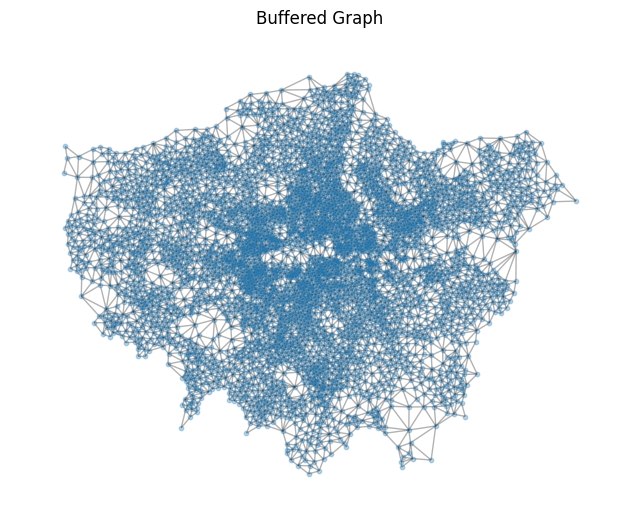

In [ ]:
# Create a mapping for the coordinates of each LSOA
LSOA_to_centroids = {node: (G_new.nodes[node]['point'].x, G_new.nodes[node]['point'].y) for node in G_new.nodes}

# Draw the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G_new, pos=LSOA_to_centroids, with_labels=False, node_size=10, alpha=0.3, ax=ax)
ax.set_aspect('equal')  # ensures an equal aspect ratio
plt.title("Buffered Graph")
plt.show()

## Random Walk
https://igraph.org/r/doc/random_walk.html

<Axes: >

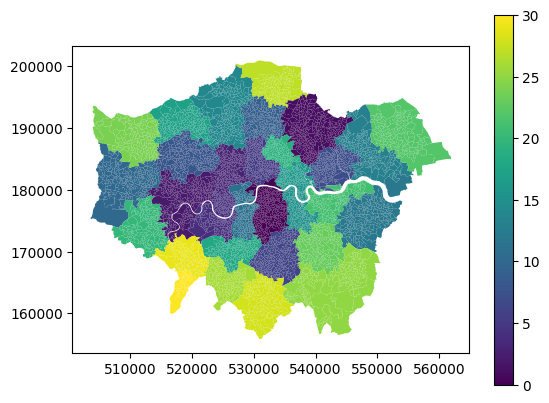

In [ ]:
# Convert the graph to igraph because walktrap takes weights in igraph
G_ig = ig.Graph.from_networkx(G_new)

# Store a mapping of indices to node names
index_to_node = {index: node for index, node in enumerate(G_new.nodes)}

# Compute the communities
walktrap_comm = G_ig.community_walktrap(weights="weight", steps=50)
communities = walktrap_comm.as_clustering()

# Convert communities to list of lists (of nodes), mapping indices back to node names
communities = [[index_to_node[index] for index in community] for community in communities]

# Create NodeClustering object
partitions = NodeClustering(communities, G_new, "Walktrap")

# Assign the community id to each node
for i, community in enumerate(partitions.communities):
    for node in community:
        G_new.nodes[node]["community"] = i

# Create a DataFrame from the graph
graph_df = pd.DataFrame.from_records([{"LSOA21CD": node, **data} for node, data in G_new.nodes(data=True)])

# Merge the DataFrame with the GeoDataFrame
age_merged_communities = age_merged.merge(graph_df, on='LSOA21CD')

# Plot the choropleth map
age_merged_communities.plot(column='community', cmap='viridis', legend=True)


## Modularity
https://igraph.org/python/doc/api/igraph.Graph.html

In [ ]:
# Create a reverse mapping from node names to indices
node_to_index = {node: index for index, node in index_to_node.items()}

# Create a membership list from the communities
membership = [0] * len(G_ig.vs)
for community_id, community in enumerate(communities):
    for node in community:
        # Use the reverse mapping to get the index of the node
        index = node_to_index[node]
        membership[index] = community_id

# Compute modularity using the membership list
modularity_score = G_ig.modularity(membership, weights="weight")

print(f"Modularity Score: {modularity_score}")

Modularity Score: 0.8820218015220075


In [ ]:
num_comm_age = age_merged_communities['community'].unique()
np.sort(num_comm_age)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

## Mapping

Merge back and find the median score per community

In [ ]:
# Merge 'score' back to the GeoDataFrame so we can work with communities
age_merged_communities['score'].fillna(0, inplace=True) # to account for r5r error
age_community_scores = age_merged_communities.groupby('community')['score'].median()
age_community_scores_df = age_community_scores.reset_index()
age_comm_and_score = age_merged_communities.merge(age_community_scores_df, how='left', on='community', suffixes=('', '_median'))
dissolved_age = age_comm_and_score.dissolve(by='community')

In [ ]:
# To get the communities back
dissolved_age = dissolved_age.reset_index()

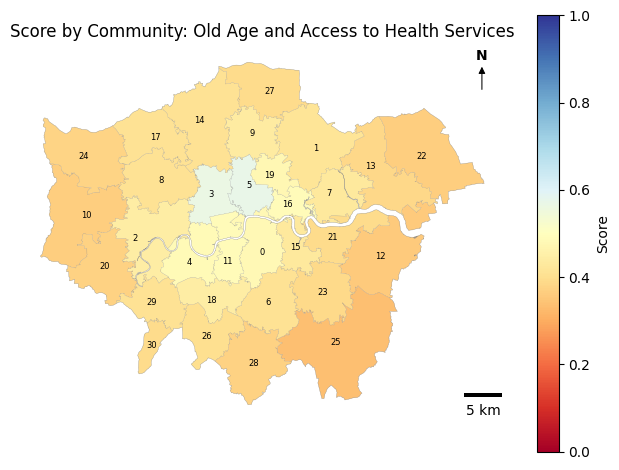

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots()

# First plot the all_london to lay the base
all_london.boundary.plot(ax=ax, color='grey', linewidth=0.25, alpha=0.5)
ax.axis('off')

# Then the actual map
dissolved_age.plot(column='score_median', cmap='RdYlBu', edgecolor='grey', linewidth=0.1, legend=False, ax=ax, vmin=0, vmax=1)
ax.axis('off')
ax.set_title('Score by Community: Old Age and Access to Health Services')

# Create and customise the legend manually
norm = plt.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdYlBu'), ax=ax, orientation='vertical')
cbar.set_label("Score")

# Add labels for each polygon based on the community value
for x, y, label in zip(dissolved_age.geometry.representative_point().x, dissolved_age.geometry.representative_point().y, dissolved_age['community']):
    ax.text(x, y, label, fontsize=6, ha='center', va='center')

# Add scale bar
scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Enhanced North arrow with patch
arrow_x = 0.95  # position to upper right
arrow_y = 0.95  # position to upper right
arrow_length = 0.075  # Reduced size for a smaller arrow

ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y-arrow_length),
            xycoords=ax.transAxes,
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='-|>', lw=0.75),
            ha='center', va='center')

# Labeling the North arrow
ax.text(arrow_x, arrow_y+0.02, 'N', ha='center', va='center', fontweight='bold', fontsize=10, transform=ax.transAxes)

# Show the map
plt.tight_layout()
plt.show()

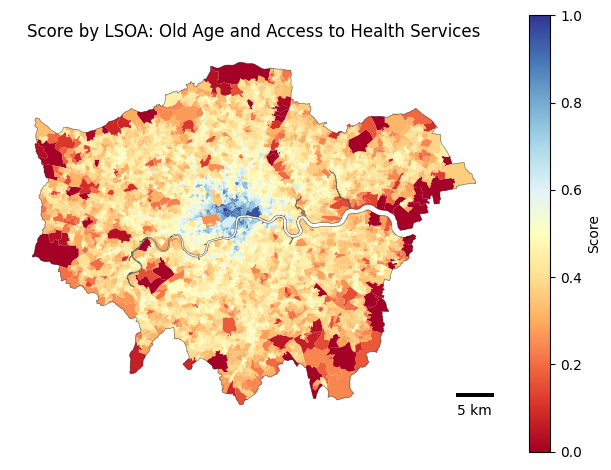

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots()

# First plot the all_london to lay the base
all_london.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5)
ax.axis('off')

# Plot the data
age_merged.plot(column='score', cmap='RdYlBu',  edgecolor='black', linewidth=0, legend=False, ax=ax, vmin=0, vmax=1)
ax.set_title("Score by LSOA: Old Age and Access to Health Services")
ax.axis('off')

# Create and customise the legend manually
norm = plt.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdYlBu'), ax=ax, orientation='vertical')
cbar.set_label("Score")

# Add scale bar
scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Show the map
plt.tight_layout()
plt.show()

In [ ]:
age_merged.score.median()

0.4241828024750652

## Unscaled Score

In [ ]:
# Create a DataFrame from the scores dictionary
unscaled_age = pd.DataFrame.from_dict(final_age_scores_unscaled_scaled, orient='index', columns=['score'])
unscaled_age.reset_index(inplace=True)
unscaled_age.rename(columns={'index':'LSOA21CD'}, inplace=True)
lsoas_unscaled_age = lsoas_london.copy()
# Merge the lsoas_london shapefile with the standardised scores DataFrame based on the 'LSOA21CD' column
unscaled_age_final = lsoas_unscaled_age.merge(unscaled_age, on='LSOA21CD')
unscaled_age_final = unscaled_age_final.fillna(0)

In [ ]:
un = unscaled_age.merge(age_merged_communities, on='LSOA21CD')
un = un.rename(columns={'score_x':'unscaled_score'})
un['unscaled_score'].fillna(0, inplace=True)

# Group by 'community' and aggregate 'unscaled_score' using the median
un = un.groupby('community')['unscaled_score'].median()
un = un.reset_index()

# Merge this median score back into dep_merged_communities
un_f = un.merge(age_merged_communities, how='left', on='community', suffixes=('', '_median'))
un_f = un_f.drop(columns={'centroids','point'})

# Ensure 'geometry' is the active geometry
un_f = un_f.set_geometry('geometry')
dissolved_un_f = un_f.dissolve(by='community', aggfunc={'unscaled_score': 'median'})

In [ ]:
dissolved_un_f = dissolved_un_f.reset_index()

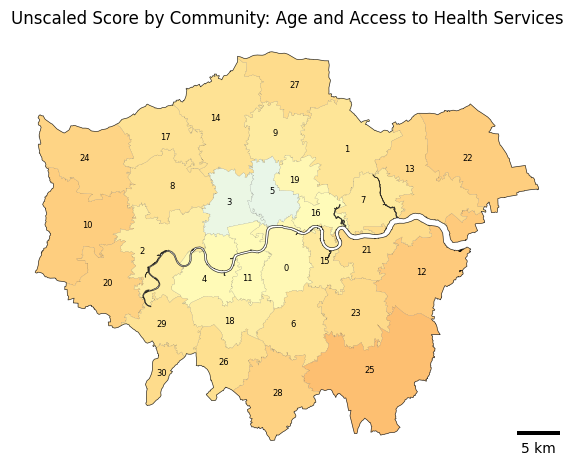

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots()

# First plot the all_london to lay the base
all_london.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.75)
ax.axis('off')

# Plot the data
dissolved_un_f.plot(column='unscaled_score', cmap='RdYlBu',  edgecolor='black', linewidth=0.05, legend=False, ax=ax, vmin=0, vmax=1)
ax.set_title("Unscaled Score by Community: Age and Access to Health Services")
ax.axis('off')

# Add labels for each polygon based on the community value
for x, y, label in zip(dissolved_un_f.geometry.representative_point().x, dissolved_un_f.geometry.representative_point().y, dissolved_un_f['community']):
    ax.text(x, y, label, fontsize=6, ha='center', va='center')

# Add scale bar
scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Show the map
plt.tight_layout()
plt.show()

## Plot the concentration of older people

In [ ]:
old_pop = data_frames[0][data_frames[0]['Age (6 categories) Code'] == 6]

# Create a list of tuples containing LSOA codes and their corresponding 'cc45' values
lsoa_cc6_values = [(lsoa_code, data['census'].get('cc6', np.nan)) for lsoa_code, data in data_dict.items()]

# Convert the list of tuples to a DataFrame
cc6_df = pd.DataFrame(lsoa_cc6_values, columns=['LSOA', 'cc6_value'])

old_pop_gdf = old_pop.merge(cc6_df, left_on='Lower layer Super Output Areas Code', right_on ="LSOA")

<Axes: >

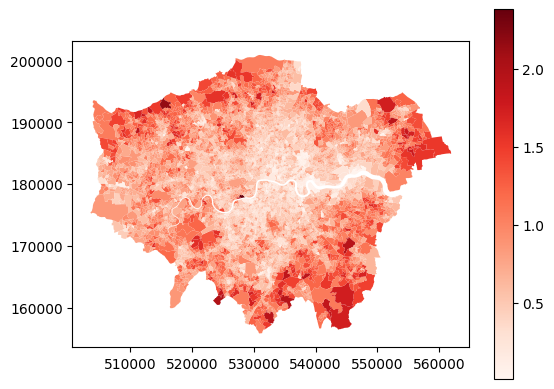

In [ ]:
# Plot the concentrations per LSOA
lsoa_age_pop = lsoas_london.copy()
old_pop_gdf2 = lsoa_age_pop.merge(old_pop_gdf, left_on='LSOA21CD', right_on ="Lower layer Super Output Areas Code")
old_pop_gdf2.plot(column='cc6_value', cmap='Reds', linewidth=0.01, legend=True)

In [ ]:
old_pop_gdf2.cc6_value.mean()

0.709095667207544

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


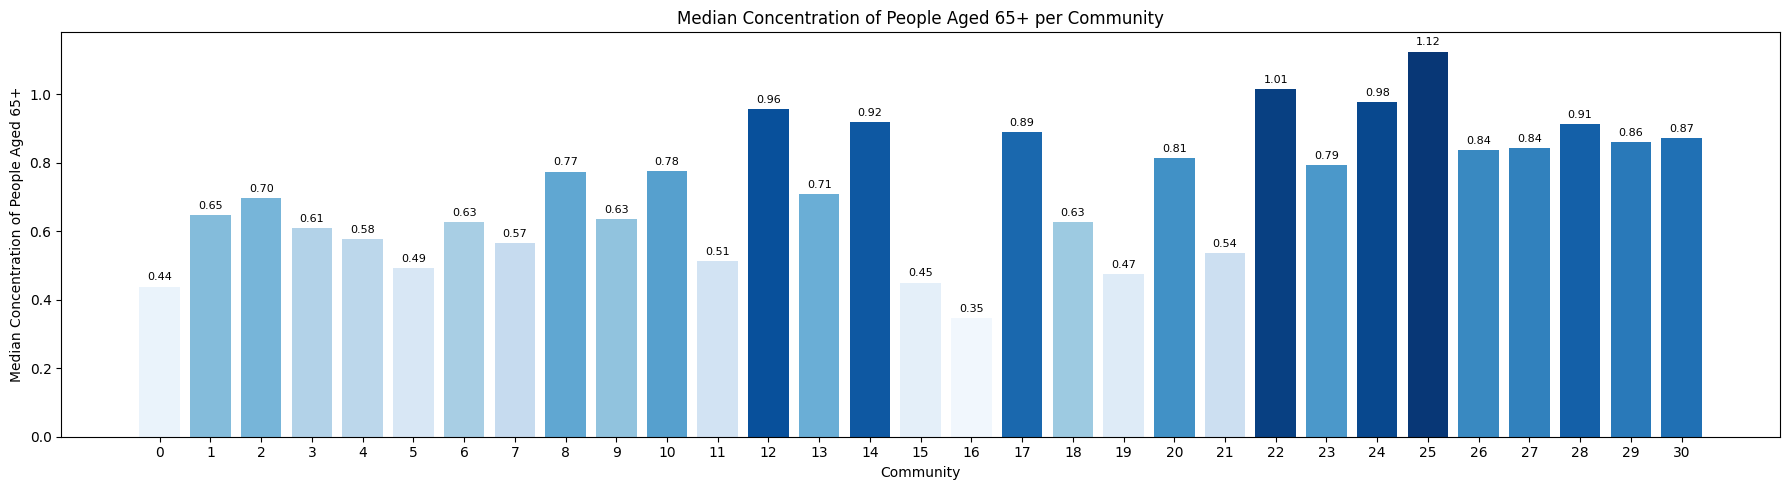

In [ ]:
# Ensure the dataframes are in the same projection
if old_pop_gdf2.crs != "EPSG:3857":
    old_pop_gdf2 = old_pop_gdf2.to_crs(epsg=3857)

if dissolved_age.crs != "EPSG:3857":
    dissolved_age = dissolved_age.to_crs(epsg=3857)

# Perform a spatial join
intersected_lsoas = gpd.sjoin(old_pop_gdf2, dissolved_age, how="inner", op='intersects')

# Group by community and sum the number of older people
community_sum_old = intersected_lsoas.groupby('community')['cc6_value'].median()

# Plot the results as a vertical bar chart
fig, ax = plt.subplots(figsize=(18, 5))

communities = community_sum_old.index.tolist()
sum_age = community_sum_old.values.tolist()

# Define a continuous blue color palette using seaborn
blue_palette = sns.color_palette("Blues", len(sum_age))
sorted_sum_age, sorted_communities = zip(*sorted(zip(sum_age, communities)))

bars = ax.bar(sorted_communities, sorted_sum_age, color=blue_palette)

# Annotate the bars with the actual numbers
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=8)

ax.set_ylabel('Median Concentration of People Aged 65+')
ax.set_xticks(communities)
ax.set_xlabel('Community')
ax.set_title('Median Concentration of People Aged 65+ per Community')
plt.tight_layout()
plt.xticks()
plt.show()

In [ ]:
community_sum_old.mean()

0.7192041072183694

## Case Study Communities

In [ ]:
dissolved_age.score_median.sort_values()

25   0.34
12   0.36
10   0.37
22   0.37
20   0.37
28   0.37
24   0.38
13   0.39
23   0.39
30   0.39
27   0.39
21   0.39
26   0.40
17   0.41
14   0.41
8    0.41
6    0.41
29   0.41
1    0.41
7    0.43
15   0.43
9    0.43
18   0.44
2    0.44
19   0.47
0    0.48
4    0.48
16   0.49
11   0.49
3    0.56
5    0.57
Name: score_median, dtype: float64

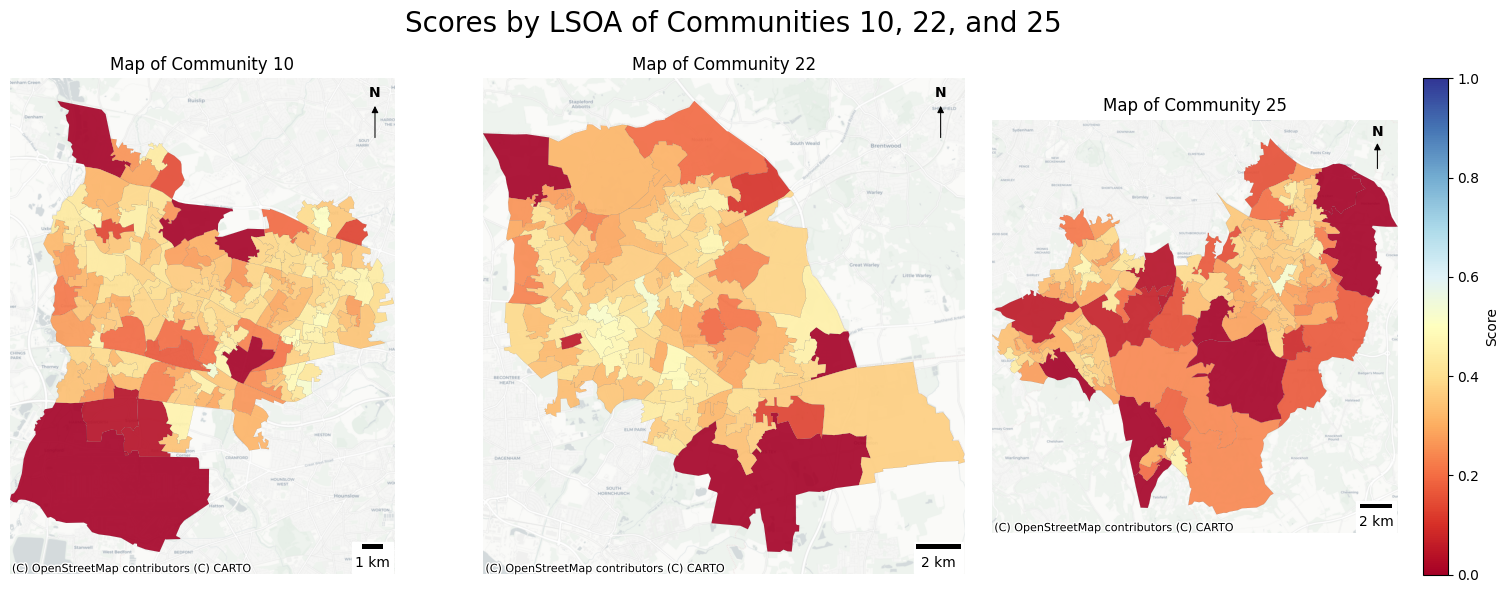

In [ ]:
# Filter only a few communities
selected_communities = age_comm_and_score[age_comm_and_score['community'].isin([10,22,25])]

# Convert to Web Mercator (EPSG:3857) so they're the same
if selected_communities.crs != "EPSG:3857":
    selected_communities = selected_communities.to_crs(epsg=3857)

# Create the figure and axes in a 1x2 grid
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

# Common color scale for both plots
vmin, vmax = 0, 1

for idx, (ax, community) in enumerate(zip(axs, [10,22,25])):
    # Subset for the specific community
    subset = selected_communities[selected_communities['community'] == community]

    # Calculate a buffer based on the height of the subset data
    buffer = 0.05 * (subset.total_bounds[3] - subset.total_bounds[1])

    # Set the axis limits
    ax.set_xlim(subset.total_bounds[0], subset.total_bounds[2])
    ax.set_ylim(subset.total_bounds[1] - buffer, subset.total_bounds[3]+buffer)

    # Add the basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Plot the subset data
    subset.plot(column='score', cmap='RdYlBu', linewidth=0.05, edgecolor='0.1', legend=False, ax=ax, alpha=0.9, vmin=vmin, vmax=vmax)

    # Remove axis borders
    ax.set_axis_off()

    # Title
    ax.set_title(f"Map of Community {community}", fontsize=12)

    # Scale bar
    scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom', length_fraction=0.1)
    ax.add_artist(scalebar)

    # North arrow
    arrow_x = 0.95
    arrow_y = 0.95
    arrow_length = 0.075

    ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y-arrow_length),
                xycoords=ax.transAxes,
                arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='-|>', lw=0.75),
                ha='center', va='center')

    # Labeling the North arrow
    ax.text(arrow_x, arrow_y+0.02, 'N', ha='center', va='center', fontweight='bold', fontsize=10, transform=ax.transAxes)

# Create and customise the legend manually
norm = plt.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdYlBu'), ax=ax, orientation='vertical')
cbar.set_label("Score")

# Adjust layout for better presentation
fig.suptitle('Scores by LSOA of Communities 10, 22, and 25', fontsize=20)
plt.tight_layout()
plt.show()

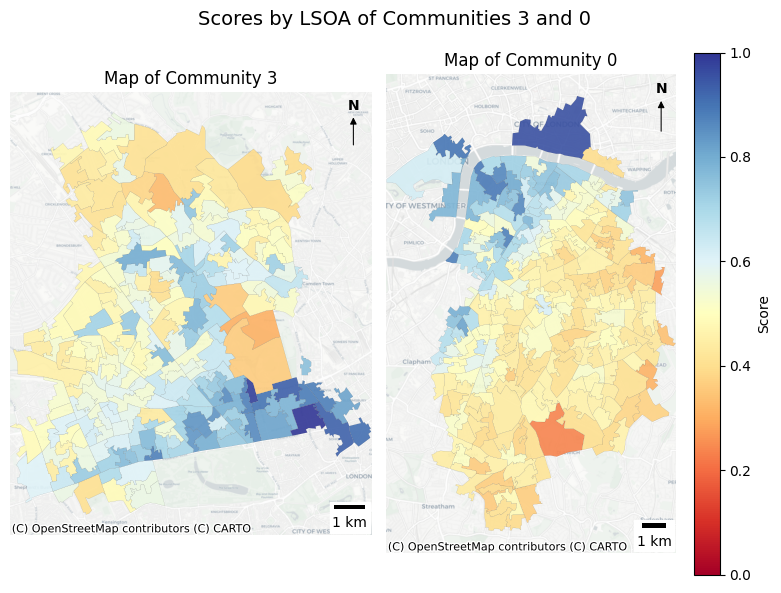

In [ ]:
# Filter only a few communities
selected_communities = age_comm_and_score[age_comm_and_score['community'].isin([3,0])]

# Convert to Web Mercator (EPSG:3857) so they're the same
if selected_communities.crs != "EPSG:3857":
    selected_communities = selected_communities.to_crs(epsg=3857)

# Create the figure and axes in a 1x2 grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

# Common color scale for both plots
vmin, vmax = 0, 1

for idx, (ax, community) in enumerate(zip(axs, [3,0])):
    # Subset for the specific community
    subset = selected_communities[selected_communities['community'] == community]

    # Calculate a buffer based on the height of the subset data
    buffer = 0.05 * (subset.total_bounds[3] - subset.total_bounds[1])

    # Set the axis limits
    ax.set_xlim(subset.total_bounds[0], subset.total_bounds[2])
    ax.set_ylim(subset.total_bounds[1] - buffer, subset.total_bounds[3]+buffer)

    # Add the basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Plot the subset data
    subset.plot(column='score', cmap='RdYlBu', linewidth=0.05, edgecolor='0.1', legend=False, ax=ax, alpha=0.9, vmin=vmin, vmax=vmax)

    # Remove axis borders
    ax.set_axis_off()

    # Title
    ax.set_title(f"Map of Community {community}", fontsize=12)

    # Scale bar
    scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom', length_fraction=0.1)
    ax.add_artist(scalebar)

    # North arrow
    arrow_x = 0.95  # position to upper right
    arrow_y = 0.95  # position to upper right
    arrow_length = 0.075  # Size of the arrow

    ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y-arrow_length),
                xycoords=ax.transAxes,
                arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='-|>', lw=0.75),
                ha='center', va='center')

    # Labeling the North arrow
    ax.text(arrow_x, arrow_y+0.02, 'N', ha='center', va='center', fontweight='bold', fontsize=10, transform=ax.transAxes)

# Create and customise the legend manually
norm = plt.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdYlBu'), ax=ax, orientation='vertical')
cbar.set_label("Score")

# Adjust layout for better presentation
fig.suptitle('Scores by LSOA of Communities 3 and 0', fontsize=14)
plt.tight_layout()
plt.show()

## Decomposed Score

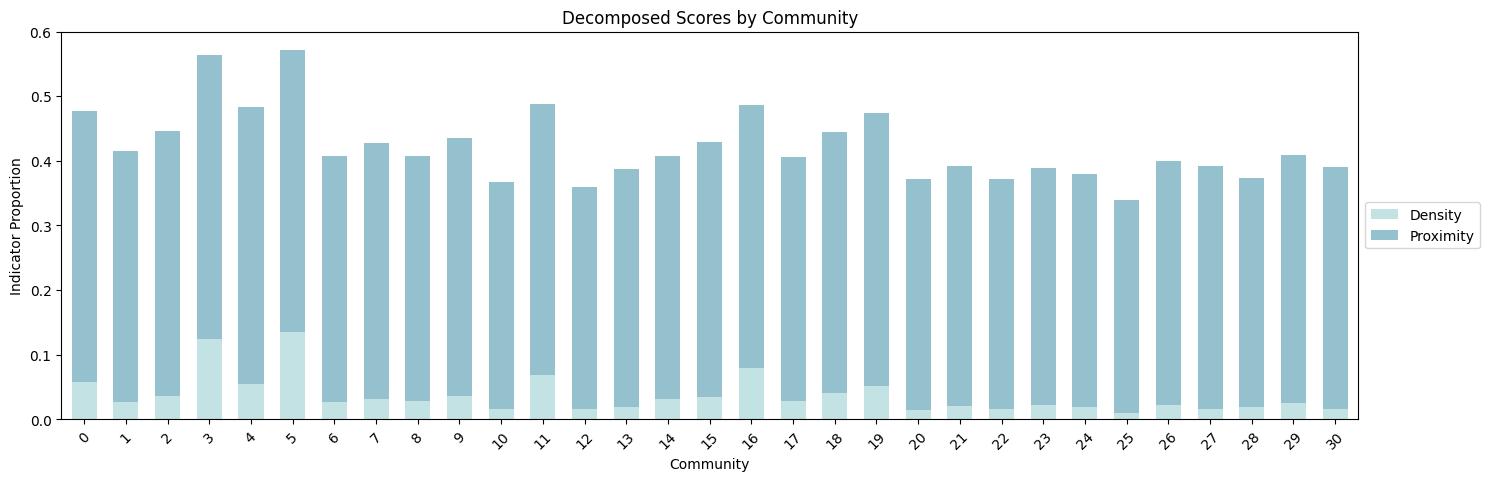

In [ ]:
# Convert the dictionary to a DataFrame
final_age_scores_all_df = pd.DataFrame.from_dict(final_age_scores_all, orient='index')

# Scale each score column individually using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
for col in final_age_scores_all_df.columns:
    final_age_scores_all_df[col] = scaler.fit_transform(final_age_scores_all_df[[col]])

# Merging the DataFrame with graph_df to get the 'community' information
final_age_scores_all_df.reset_index(inplace=True)
final_age_scores_all_df.rename(columns={'index':'LSOA21CD'}, inplace=True)
age_allscores = final_age_scores_all_df.merge(graph_df, on='LSOA21CD')

# Group by community and compute the median values, specifying numeric_only=True
age_allscores_grouped = age_allscores.groupby('community').median(numeric_only=True)

# Compute the proportions
total = age_allscores_grouped['scaled_density'] + age_allscores_grouped['scaled_tt']
age_allscores_grouped['density_prop'] = (age_allscores_grouped['scaled_density'] / total) * age_allscores_grouped['final_score']
age_allscores_grouped['tt_prop'] = (age_allscores_grouped['scaled_tt'] / total) * age_allscores_grouped['final_score']

# Plotting the stacked bar chart to visualise the decomposed scores by community
fig, ax = plt.subplots(figsize=(15, 5))
age_allscores_grouped[['density_prop', 'tt_prop']].plot(kind='bar', stacked=True,
                                                       ax=ax, color=sns.color_palette("ch:start=.2,rot=-.3"),
                                                       width=0.6, legend=None)

# Customising the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['Density', 'Proximity']
ax.legend(handles, new_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Decomposed Scores by Community')
plt.ylabel('Indicator Proportion')
plt.xlabel('Community')
plt.xticks(rotation=45)

# Adjust the layout and set the bottom margin
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.show()


## Sensitivity Testing with Time Series Data

In [ ]:
age_sens = copy.deepcopy(data_dict)

In [ ]:
# Function to get the integer part from the filename for sorting files
def get_integer_from_filename(filename):
    basename = os.path.basename(filename)
    pure_name = os.path.splitext(basename)[0]
    num = ''.join(filter(str.isdigit, pure_name))
    return int(num)

In [ ]:
# Load all CSV files into a list of DataFrames
folder_path = "YOUR_PATH_HERE/Data/r5r Data/Age_sensitivity"
all_files = os.listdir(folder_path)
csv_files = [file for file in all_files if file.endswith('.csv')]

# Sort the files based on the integer part of their filename
csv_files.sort(key=get_integer_from_filename)

dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]

### Calculate Scores for all dfs

The below code captures much of what was done above but it does it for all of the dfs involved in sensitivity testing. It builds upon the same initial census vector.

In [ ]:
# Create an instance of StandardScaler
scaler = StandardScaler()

# Define a dictionary to store the final vectors for each LSOA
final_vectors_dict = {}

# Define a dictionary to store the final scores for each LSOA
final_scores_dict = {}

# Loop over all dataframes
for idx, df_current in enumerate(dataframes):
    # Copy the dataframe to avoid modifying the original
    df_processed = df_current.copy()

    # Remove rows with 'inf' or 'nan' in 'travel_time_p50'
    old_length = len(df_processed)
    df_processed = df_processed[df_processed["travel_time_p50"] != float('inf')]
    df_processed = df_processed.dropna(subset=['travel_time_p50'])
    new_length = len(df_processed)
    print(f"Dropped {old_length - new_length} rows due to 'inf' or 'nan' values.")

    # Apply the StandardScaler to the 'travel_time_p50' column
    df_processed['zscore_tt'] = scaler.fit_transform(df_processed[['travel_time_p50']])

    # Compute the density and then standardise it
    df_processed['density'] = df_processed['accessibility'] / 24264
    df_processed['density_zscore'] = scaler.fit_transform(df_processed[['density']])

    # Loop over all rows in the dataframe
    for _, row in df_processed.iterrows():
        # Get the LSOA code
        lsoa_code = row['LSOA21CD']

        # Get the features for the final vector, corresponds to older people
        old = lsoa_data['census']['cc6'] if lsoa_code in age_sens else np.nan
        density = row['density_zscore']
        tt = row['zscore_tt']

        # Create the final vector
        vector = np.array([old, density, tt])

        # Store the final vector for the LSOA
        if lsoa_code not in final_vectors_dict:
            final_vectors_dict[lsoa_code] = []
        final_vectors_dict[lsoa_code].append(vector)

        # Find the max z-score for inverting the travel time
        max_z = df_processed['zscore_tt'].max()

        # Calculate the Scores
        scaled_tt = max_z - tt

        # Normalise by LSOA area
        final_score = density + scaled_tt
        if lsoa_code in lsoas_london.index:
            area = lsoas_london.loc[lsoa_code, 'area']
            if area > 0 :
                final_score_norm = (final_score / area) * (1/old)

        # Store the final score for the LSOA
        if lsoa_code not in final_scores_dict:
          final_scores_dict[lsoa_code] = []
        final_scores_dict[lsoa_code].append(final_score)

Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'nan' values.
Dropped 60 rows due to 'inf' or 'n

In [ ]:
# Convert the dictionary to a DataFrame
final_scores_df = pd.DataFrame.from_dict(final_scores_dict, orient='index')

# Calculate the score for each LSOA at each time point
final_scores_df['score'] = final_scores_df.apply(lambda row: np.mean([score for score in row if not np.isnan(score)]), axis=1)

# Scale each score column individually
scaler = MinMaxScaler(feature_range=(0,1))
for col in final_scores_df.columns:
    final_scores_df[col] = scaler.fit_transform(final_scores_df[[col]])

# Add back in 0 scores to account for r5r missing scores
final_scores_df['score'].fillna(0, inplace=True)

In [ ]:
# Transpose the DataFrame, so that each row represents a time point
final_scores_df_T = final_scores_df.transpose()

# Calculate the summary statistics for each time point
summary_statistics = final_scores_df.describe()

summary_statistics_formatted = summary_statistics.applymap(lambda x: '{:.4f}'.format(x))
summary_statistics_formatted

0          1          2          3          4          5  \
count  4934.0000  4934.0000  4934.0000  4934.0000  4934.0000  4934.0000   
mean      0.4364     0.4299     0.4292     0.4281     0.4279     0.4301   
std       0.1142     0.1127     0.1124     0.1121     0.1117     0.1124   
min       0.0000     0.0000     0.0000     0.0000     0.0000     0.0000   
25%       0.3705     0.3653     0.3647     0.3643     0.3638     0.3659   
50%       0.4299     0.4237     0.4231     0.4223     0.4222     0.4242   
75%       0.4867     0.4791     0.4780     0.4769     0.4772     0.4795   
max       1.0000     1.0000     1.0000     1.0000     1.0000     1.0000   

               6          7          8          9  ...         18         19  \
count  4934.0000  4934.0000  4934.0000  4934.0000  ...  4934.0000  4934.0000   
mean      0.4316     0.4352     0.4344     0.4341  ...     0.4337     0.4347   
std       0.1127     0.1138     0.1134     0.1135  ...     0.1135     0.1139   
min       0.0000     0.0000     0.0000     0.0000  ...     0.0000     0.0000   
25%       0.3674     0.3699     0.3697     0.3693  ...     0.3684     0.3699   
50%       0.4259     0.4292     0.4287     0.4282  ...     0.4273     0.4284   
75%       0.4815     0.4853     0.4846     0.4840  ...     0.4827     0.4837   
max       1.0000     1.0000     1.0000     1.0000  ...     1.0000     1.0000   

              20         21         22         23         24         25  \
count  4934.0000  4934.0000  4934.0000  4934.0000  4934.0000  4934.0000   
mean      0.4355     0.4366     0.4361     0.4378     0.4407     0.4395   
std       0.1140     0.1142     0.1139     0.1143     0.1151     0.1147   
min       0.0000     0.0000     0.0000     0.0000     0.0000     0.0000   
25%       0.3705     0.3713     0.3712     0.3722     0.3749     0.3738   
50%       0.4289     0.4299     0.4296     0.4315     0.4345     0.4335   
75%       0.4845     0.4860     0.4853     0.4876     0.4917     0.4905   
max       1.0000     1.0000     1.0000     1.0000     1.0000     1.0000   

              26      score  
count  4934.0000  4934.0000  
mean      0.4429     0.4344  
std       0.1159     0.1135  
min       0.0000     0.0000  
25%       0.3760     0.3699  
50%       0.4370     0.4285  
75%       0.4949     0.4842  
max       1.0000     1.0000  

[8 rows x 28 columns]

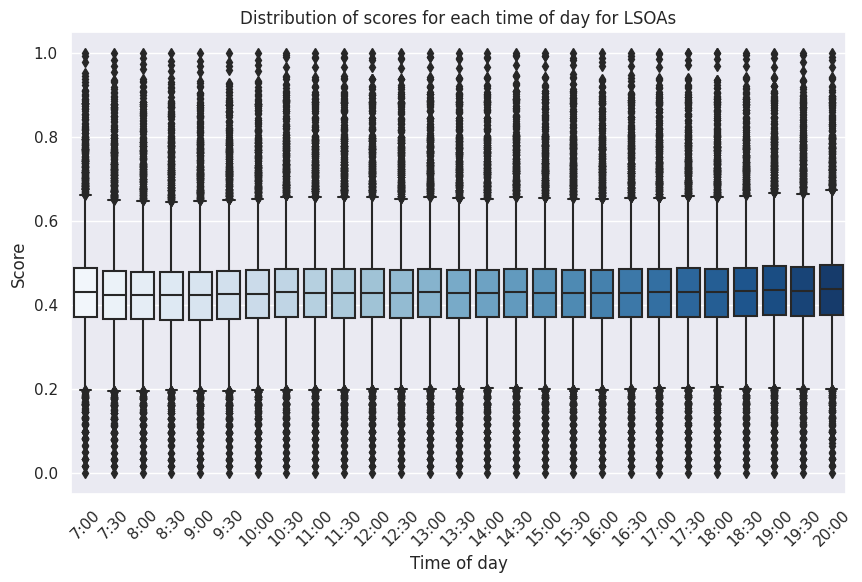

In [ ]:
sns.set(style="darkgrid")

# Create a copy
final_scores_df_copy = final_scores_df.copy()

# Drop the 'score' column
final_scores_df_copy = final_scores_df_copy.drop(columns=['score'])

# Convert column names to integers, sort, and then convert back to strings
final_scores_df_copy.columns = final_scores_df_copy.columns.astype(int)
final_scores_df_copy = final_scores_df_copy.sort_index(axis=1)
final_scores_df_copy.columns = final_scores_df_copy.columns.astype(str)

# Define time labels
time_mapping = {
    0:'7:00', 1:'7:30', 2:'8:00', 3:'8:30', 4:'9:00', 5:'9:30', 6:'10:00',
    7:'10:30', 8:'11:00', 9:'11:30', 10:'12:00', 11:'12:30', 12:'13:00',
    13:'13:30', 14:'14:00', 15:'14:30', 16:'15:00', 17:'15:30', 18:'16:00',
    19:'16:30', 20:'17:00', 21:'17:30', 22:'18:00', 23:'18:30', 24:'19:00',
    25:'19:30', 26:'20:00'
}

# Apply time mapping to columns
final_scores_df_copy.columns = [time_mapping[int(col)] for col in final_scores_df_copy.columns]

# Boxplot for each time of day in numerical order
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_scores_df_copy, palette="Blues")
plt.title('Distribution of scores for each time of day for LSOAs')
plt.xlabel('Time of day')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()